## Test CLIP

In [ ]:
import pickle as pkl
import argparse
import os
import pickle
import random
import numpy as np
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from pcbm.data import get_dataset
from pcbm.concepts import ConceptBank
from pcbm.models import PosthocLinearCBM, get_model
from pcbm.training_tools import load_or_compute_projections

UNIVERSAL_SEED = 2024
BATCH_SIZE = 64
NUM_WORKERS = 4
CONCEPT_BANK_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl"
OUT_PUT_DIR_PATH = "exps/test"
CKPT_PATH = "data/ckpt/CIFAR_10/pcbm_cifar10__clip:RN50__multimodal_concept_clip:RN50_cifar10_recurse:1__lam:0.0002__alpha:0.99__seed:42.ckpt"
DATASET_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank"
BACKBONE_NAME = "clip:ViT-B/32"
DEVICE = "cuda"

In [ ]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_seed(UNIVERSAL_SEED)

In [ ]:
all_concepts = pkl.load(open(CONCEPT_BANK_PATH, 'rb'))
all_concept_names = list(all_concepts.keys())
print(f"Bank path: {CONCEPT_BANK_PATH}. {len(all_concept_names)} concepts will be used.")
concept_bank = ConceptBank(all_concepts, DEVICE)

import clip
clip_backbone_name = BACKBONE_NAME.split(":")[1]
backbone, preprocess = clip.load(clip_backbone_name, device=DEVICE, download_root="/home/ksas/Public/model_zoo/clip")
backbone = backbone.eval()
backbone = backbone.float()
model = None

backbone = backbone.to(DEVICE)
backbone.eval()

In [ ]:
backbone.visual

In [ ]:
with open("cifar10_concept.txt", "w+") as input_stream:
    for idx, concept_name in enumerate(concept_bank.concept_info.concept_names):
        input_stream.write(f"{idx}\t-{concept_name}\n")

In [ ]:
posthoc_layer:PosthocLinearCBM = torch.load(CKPT_PATH, map_location=DEVICE)
print(posthoc_layer.analyze_classifier(k=5))
print(posthoc_layer.names)
print(posthoc_layer.names.__len__())

In [ ]:
from torchvision import datasets
from pcbm.learn_concepts_multimodal import *
trainset = datasets.CIFAR10(root=DATASET_PATH, train=True,
                            download=True, transform=preprocess)
testset = datasets.CIFAR10(root=DATASET_PATH, train=False,
                            download=True, transform=preprocess)
classes = trainset.classes
class_to_idx = {c: i for (i,c) in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                    shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
def show_image(images:torch.Tensor):
    import torch
    import torchvision
    import matplotlib.pyplot as plt

    # 使用 torchvision.utils.make_grid 将 64 张图片排列成 8x8 的网格
    grid_img = torchvision.utils.make_grid(images, nrow=8, normalize=True)

    # 转换为 NumPy 格式以便用 matplotlib 显示
    plt.imshow(grid_img.permute(1, 2, 0))  # 转换为 [H, W, C]
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

for idx, data in enumerate(train_loader):
    print(data.__len__())
    print(f"x: {data[0].size()}")
    print(f"y: {data[1].size()}")
    batch_X, batch_Y = data
    batch_X = batch_X.to(DEVICE)
    batch_Y = batch_Y.to(DEVICE)
    
    batch_X.requires_grad_(True)
    embeddings = backbone.encode_image(batch_X)
    projs = posthoc_layer.compute_dist(embeddings)
    predicted_Y = posthoc_layer.forward_projs(projs)
    accuracy = (predicted_Y.argmax(1) == batch_Y).float().mean().item()
    
    _, topk_indices = torch.topk(projs, 5, dim=1)
    topk_concept = [[posthoc_layer.names[idx] for idx in row] for row in topk_indices]

    
    show_image(batch_X.detach().cpu())
    print(f"embeddings: {embeddings.size()}")
    print(f"projections: {projs.size()}")
    print(f"predicted_Y: {predicted_Y.size()}")
    print(f"accuracy: {accuracy}")
    # accuracy_idx.append(accuracy)
    import pdb; pdb.set_trace()
    
# print(accuracy_idx)
    

In [ ]:
import pickle as pkl
import os
from constants import dataset_cosntants
from pcbm.data.cub import CUBConceptDataset, get_concept_dicts
from pcbm.concepts import ConceptBank

CUB_CONCEPT_BANK_PATH =  "/home/ksas/Public/datasets/cub_concept_bank/cub_resnet18_cub_0.1_100.pkl"
DEVICE = "cuda"

TRAIN_PKL = os.path.join(dataset_cosntants.CUB_PROCESSED_DIR, "train.pkl")
metadata = pkl.load(open(TRAIN_PKL, "rb"))

concept_info = get_concept_dicts(metadata=metadata)
concept_info[0].keys()

In [ ]:
print(concept_info.__len__())
print(concept_info[0][0].__len__())
print(concept_info[0][1].__len__())

## Test Layer Grad CAM

In [8]:
import clip
from clip.model import CLIP, ModifiedResNet, VisionTransformer
import torch
from PIL import Image
import torchvision.transforms as transforms

BACKBONE_NAME = "clip:RN50"
DEVICE = "cuda:1"
clip_backbone_name = BACKBONE_NAME.split(":")[1]
backbone, preprocess = clip.load(clip_backbone_name, device=DEVICE, download_root="/home/ksas/Public/model_zoo/clip")
backbone = backbone.eval()
backbone = backbone.float()
normalizer = transforms.Compose(preprocess.transforms[-1:])
preprocess = transforms.Compose(preprocess.transforms[:-1])
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x708540ea6340>
    ToTensor()
)


In [10]:
from utils.explain_utils import *
from captum.attr import visualization, GradientAttribution, LayerAttribution

# image_attn_blocks = list(dict(backbone.visual.transformer.resblocks.named_children()).values())
# last_blocks = image_attn_blocks[-1].ln_1
# layer_grad_cam = layer_grad_cam_vit(backbone,
#                                 last_blocks)
wrapped_backbone = lambda input, text: backbone(input, text)[0]
saliency_map = model_explain_algorithm_factory.saliency_map(wrapped_backbone)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


(tensor([[13.0914, 17.8872, 17.9667]], device='cuda:1', grad_fn=<MmBackward0>), tensor([[13.0914],
        [17.8872],
        [17.9667]], device='cuda:1', grad_fn=<TBackward0>))


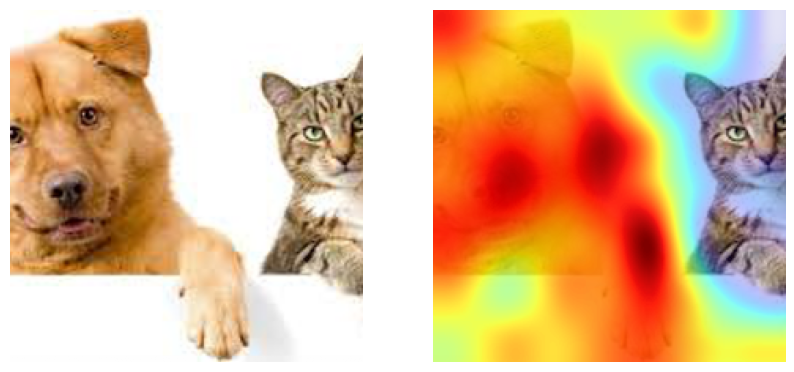

/home/ksas/miniconda3/envs/env_pcbm_base/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].


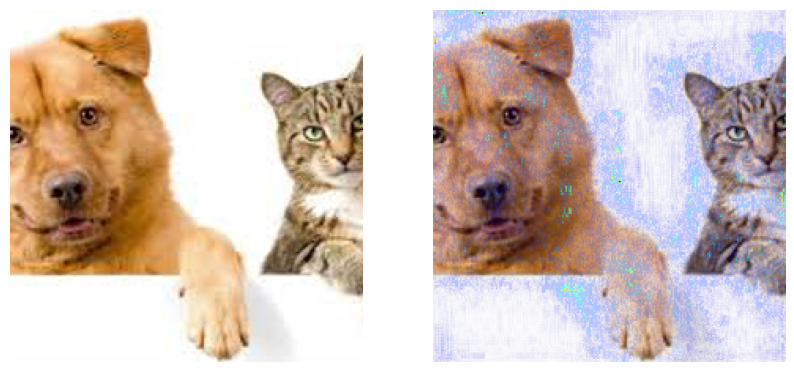

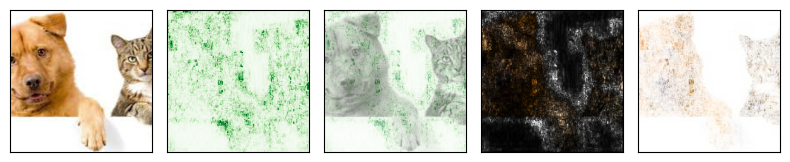

In [11]:
from utils.visual_utils import *

image:torch.Tensor = preprocess(Image.open("data/images/cat_and_dog.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["car", "a dog", "a cat"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 1, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr.squeeze(),
        blur=False,
        save_to=None)

attributions:torch.Tensor = saliency_map.attribute(normalizer(image), 1, additional_forward_args = text)

viz_attn(image,
        attributions.squeeze(),
        blur=False,
        save_to=None)

captum_vis_attn(image, attributions.squeeze())


In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/multi_dog_and_cat.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["cat and dog", "dog", "cat", "many dogs", "many cats", "eyees"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 5, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)


In [ ]:
image:torch.Tensor = preprocess(Image.open("data/layer_grad_cam/propellers_images/946-original_image.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["airplane", "propellers", "landing gear"]).to(DEVICE)
print(backbone(normalizer(image), text))

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 0, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 1, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)


In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/dog_cat.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["car", "dog", "cat"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 2, additional_args = {"text": text})
print(attributions)
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=False,
        save_to=None)

In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/glasses.png")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["man with eyeglasses"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 0, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

In [ ]:
image:torch.Tensor = preprocess(Image.open("data/images/airplane.jpg")).unsqueeze(0).to(DEVICE)
text = clip.tokenize(["propellers",
                      "heavier-than-air craft",
                      "fuselage",
                      "accelerator",
                      "landing gear"]).to(DEVICE)
print(backbone(normalizer(image), text))
attributions:torch.Tensor = layer_grad_cam.attribute(normalizer(image), 4, additional_args = {"text": text})
upsampled_attr = LayerAttribution.interpolate(attributions, image.size()[-2:], interpolate_mode="bicubic")

viz_attn(image,
        upsampled_attr,
        blur=True,
        save_to=None)

## Test OPEN_CLIP

In [ ]:
import open_clip
open_clip.list_pretrained()

In [ ]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', cache_dir="/home/ksas/Public/model_zoo/clip")
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open("data/images/cat_and_dog.jpg")).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])
print(preprocess)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs) 

## Output CIFAR10

In [ ]:
import clip
import torch
import torch.nn as nn
from torchvision import datasets
from constants import dataset_constants
import torchvision.transforms as transforms

trainset = datasets.CIFAR10(root=dataset_constants.CIFAR10_DIR, train=True,
                            download=False, transform=None)
testset = datasets.CIFAR10(root=dataset_constants.CIFAR10_DIR, train=False,
                            download=False, transform=None)
classes = trainset.classes
class_to_idx = {c: i for (i,c) in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

print(idx_to_class)
plt.imshow(trainset[100][0])
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [ ]:
import os
from tqdm import tqdm

CIFAR10_TRAINING_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/training_imgs"
os.makedirs(CIFAR10_TRAINING_PATH, exist_ok=True)
for idx, (image, cls) in tqdm(enumerate(trainset), total=trainset.__len__()):
    image.save(os.path.join(CIFAR10_TRAINING_PATH, f"{idx:05d}_{idx_to_class[cls]}.png"), format='png')

In [ ]:
CIFAR10_TESTING_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/testing_imgs"
os.makedirs(CIFAR10_TESTING_PATH, exist_ok=True)
for idx, (image, cls) in tqdm(enumerate(testset), total=testset.__len__()):
    image.save(os.path.join(CIFAR10_TESTING_PATH, f"{idx:05d}_{idx_to_class[cls]}.png"), format='png')

In [ ]:
import pandas as pd
# 读取 CSV 文件
df = pd.read_csv('/home/ksas/Public/datasets/cifar10_concept_bank/training_imgs.csv')

# 打印前几行，验证读取是否成功
print(df.head())
print(df["filepath"])

## CLIP full-shot evaluation

In [ ]:
from open_clip import get_input_dtype, get_tokenizer, build_zero_shot_classifier, \
    IMAGENET_CLASSNAMES, OPENAI_IMAGENET_TEMPLATES
from open_clip_train.precision import get_autocast

CIFAR10_CLASSNAME = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def run(model, classifier, dataloader):
    device = torch.device("cuda")
    autocast = get_autocast("amp", device_type=device.type)
    input_dtype = get_input_dtype("amp")

    with torch.inference_mode():
        top1, top5, n = 0., 0., 0.
        for images, target in tqdm(dataloader, unit_scale=64):
            images = images.to(device=device, dtype=input_dtype)
            target = target.to(device)

            with autocast():
                # predict
                output = model(image=images)
                image_features = output['image_features'] if isinstance(output, dict) else output[0]
                logits = 100. * image_features @ classifier

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)

    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5
 
def zero_shot_eval(model, dataloader, tokenizer):
    print('Starting zero-shot imagenet.')
    print('Building zero-shot classifier')
    device = torch.device("cuda")
    autocast = get_autocast("amp", device_type=device.type)
    with autocast():
        classifier = build_zero_shot_classifier(
            model,
            tokenizer=tokenizer,
            classnames=CIFAR10_CLASSNAME,
            templates= (
                lambda c: f'a picture of a {c}.',
            ),
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )

    print('Using classifier')
    results = {}
    top1, top5 = run(model, classifier, dataloader)
    print(f"top1: {top1}, top5: {top5}")
    print('Finished zero-shot imagenet.')

    return results

In [ ]:
import torch
from PIL import Image
import open_clip
MODEL_NAME = 'ViT-B-32'
ORIGINAL_CKPT_PATH = "/home/ksas/Public/model_zoo/clip/ViT-B-32.pt"
REFINED_CKPT_PATH = "/home/ksas/uzuki_space/open_clip/src/logs/2024_10_24-10_48_09-model_ViT-B-32-lr_1e-05-b_128-j_3-p_amp/checkpoints/epoch_2.pt"
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=ORIGINAL_CKPT_PATH, cache_dir="/home/ksas/Public/model_zoo/clip")
model.cuda().eval()
tokenizer = open_clip.get_tokenizer(MODEL_NAME)

from common_utils import *

trainset, testset, class_to_idx, idx_to_class, train_loader, test_loader = load_dataset(dataset_configure(
            dataset = 'cifar10',
            batch_size = 64,
            num_workers = 4,
        ), preprocess)

zero_shot_eval(model, train_loader, tokenizer)
zero_shot_eval(model, test_loader, tokenizer)


model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=REFINED_CKPT_PATH, cache_dir="/home/ksas/Public/model_zoo/clip")
model.cuda().eval()

zero_shot_eval(model, train_loader, tokenizer)
zero_shot_eval(model, test_loader, tokenizer)


In [ ]:
from cnn import net

## Visualize CUB dataset

In [7]:
from utils import *
cub_mean_pxs = np.array([0.5, 0.5, 0.5])
cub_std_pxs = np.array([2., 2., 2.])
preprocess = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(cub_mean_pxs, cub_std_pxs)
        ])

concept_bank = load_concept_bank(concept_bank_configure(
            concept_bank = "/home/ksas/Public/datasets/cub_concept_bank/cub_resnet18_cub_0.1_100.pkl",
            device = torch.device("cuda")
        ))
backbone, preprocess = load_backbone(backbone_configure(
    backbone_name="resnet18_cub",
    backbone_ckpt = "/home/ksas/Public/model_zoo/resnet_cub",
    device = torch.device("cuda")
), full_load=False)
normalizer = transforms.Compose(preprocess.transforms[-1:])
preprocess = transforms.Compose(preprocess.transforms[:-1])

posthoc_layer = load_pcbm(pcbm_configure(
        pcbm_ckpt = "data/ckpt/CUB/vanilla_pcbm_cub__resnet18_cub__cub_resnet18_cub_0__lam:0.0002__alpha:0.99__seed:42.ckpt",
        device = torch.device("cuda")
))

# trainset, testset, class_to_idx, idx_to_class, train_loader, test_loader= load_dataset(dataset_configure(
#         dataset = "cub",
#         batch_size = 8,
#         num_workers = 4,
# ), preprocess)
print(backbone)

Bank path: /home/ksas/Public/datasets/cub_concept_bank/cub_resnet18_cub_0.1_100.pkl. 112 concepts will be used.
Concept Bank is initialized.
resnet18_cub
ResNetBottom(
  (features): Sequential(
    (0): Sequential(
      (init_block): ResInitBlock(
        (conv): ConvBlock(
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (stage1): Sequential(
        (unit1): ResUnit(
          (body): ResBlock(
            (conv1): ConvBlock(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activ): ReLU(inplace=True)
            )
            (con

In [11]:
print(backbone.get_submodule("features")
      .get_submodule("0")
      .get_submodule("stage4")
      .get_submodule("unit2")
      .get_submodule("body")
      .get_submodule("conv2")
      .get_submodule("conv"))

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
import numpy as np

from tqdm import tqdm
from utils.visual_utils import show_image

totall_accuracy = []
for idx, data in enumerate(tqdm(train_loader)):
    batch_X, batch_Y = data
    # show_image(batch_X)
    batch_X:torch.Tensor = batch_X.to(torch.device("cuda"))
    batch_Y:torch.Tensor = batch_Y.to(torch.device("cuda"))
    totall_accuracy.append((backbone(batch_X).argmax(1) == batch_Y).float().mean().item())
    # concept = posthoc_layer.compute_dist(backbone.encode_image(batch_X))
    
    # import pdb; pdb.set_trace()
    
print(np.array(totall_accuracy).mean())

## Visualize CUB concept

In [ ]:
import os
import pickle

from torch.utils.data import DataLoader
from pcbm.data.constants import CUB_PROCESSED_DIR
from pcbm.data.cub import CUBConceptDataset, get_concept_dicts

TRAIN_PKL = os.path.join(CUB_PROCESSED_DIR, "train.pkl")
metadata = pickle.load(open(TRAIN_PKL, "rb"))

concept_info = get_concept_dicts(metadata=metadata)

In [ ]:
print(metadata[0].keys())
print(metadata[0]["attribute_certainty"])

img_1 = metadata[800]
img_2 = None
print(img_1["attribute_label"].__len__())
for img in metadata[1:]:
    if img_1["class_label"] == img["class_label"]:
        print(img_1["attribute_label"] == img["attribute_label"])
        print(img_1["attribute_certainty"] == img["attribute_certainty"])

## Test casual metirc

In [3]:
import argparse
import random
import clip.model
import numpy as np
import pickle as pkl
import json
import time
from datetime import datetime
from tqdm import tqdm
from typing import Tuple, Callable, Union, Dict

import clip
from clip.model import CLIP, ModifiedResNet, VisionTransformer

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms

from pcbm.learn_concepts_multimodal import *
from pcbm.data import get_dataset
from pcbm.concepts import ConceptBank
from pcbm.models import PosthocLinearCBM, get_model

from captum.attr import visualization, GradientAttribution, LayerAttribution
from utils import *

target_classs = 3 # cat
concept_target = "sharp claws"
batch_size = 1
explain_method = "saliency_map"
device = torch.device("cuda")

concept_bank = load_concept_bank(concept_bank_configure(
    concept_bank = "/home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl",
    device = device
))
backbone, preprocess = load_backbone(backbone_configure(
    backbone_name = "open_clip:RN50",
    backbone_ckpt = "outputs/clip_adversarial_saliency_guided_training/adversarial_saliency_guided_training-open_clip:RN50.pth",
    # backbone_ckpt = "/home/ksas/Public/model_zoo/clip",
    device = device
    
))
normalizer = transforms.Compose(preprocess.transforms[-1:])
preprocess = transforms.Compose(preprocess.transforms[:-1])

posthoc_layer = load_pcbm(pcbm_configure(
    pcbm_ckpt = "data/ckpt/CIFAR_10/pcbm_cifar10__clip:RN50__multimodal_concept_clip:RN50_cifar10_recurse:1__lam:0.0002__alpha:0.99__seed:42.ckpt",
    device = device
))
dataset = load_dataset(dataset_configure(
    dataset = "cifar10",
    batch_size = batch_size,
    num_workers = 4
    ), preprocess, target_classs)
    
model_context = model_pipeline(concept_bank = concept_bank, 
                posthoc_layer = posthoc_layer, 
                preprocess = preprocess, 
                normalizer = normalizer, 
                backbone = backbone)
posthoc_concept_net = PCBM_Net(model_context=model_context)

explain_algorithm:GradientAttribution = getattr(model_explain_algorithm_factory, explain_method)(posthoc_concept_net = posthoc_concept_net)
explain_algorithm_forward:Callable = getattr(model_explain_algorithm_forward, explain_method)
targeted_concept_idx = model_context.concept_bank.concept_names.index(concept_target)
print(targeted_concept_idx)

Bank path: /home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl. 175 concepts will be used.
Concept Bank is initialized.
37


In [4]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

causal_metric = CausalMetric(model = posthoc_concept_net,
                             mode = "del",
                             step = 224,
                             substrate_fn = torch.zeros_like,
                             classes = model_context.concept_bank.concept_names.__len__())
totall_causal_metric = []
for idx, data in tqdm(enumerate(dataset.test_loader), 
                          total=dataset.test_loader.__len__()):
    batch_X, batch_Y = data
    batch_X:torch.Tensor = batch_X.to(device)
    batch_Y:torch.Tensor = batch_Y.to(device)

    batch_X.requires_grad_(True)
    attributions:torch.Tensor = explain_algorithm_forward(batch_X=batch_X, 
                                                            explain_algorithm=explain_algorithm,
                                                            target=targeted_concept_idx)
    causal_curve = causal_metric.forward(batch_X, 
                                         attributions.mean(1), 
                                         batch_X.size(0), 
                                         targeted_concept_idx * torch.ones_like(batch_Y))
    print(causal_curve.size())
    print(causal_curve)
    causal_auc = auc(causal_curve)
    totall_causal_metric.append(causal_auc.mean().item())
    # for i in range(batch_Y.size(0)):
    #     captum_vis_attn(batch_X[i:i+1], 
    #                 attributions[i:i+1], 
    #                 title=f"{dataset.idx_to_class[batch_Y[i].item()]}-attributions: {concept_target}",
    #                 save_to=None)
    import pdb; pdb.set_trace()
    
print(f"totall causal metric:{np.array(totall_causal_metric).mean()}")

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([225, 1])
tensor([[0.6759],
        [0.6443],
        [0.6391],
        [0.6343],
        [0.6298],
        [0.6203],
        [0.6150],
        [0.6130],
        [0.6074],
        [0.6000],
        [0.5902],
        [0.5793],
        [0.5734],
        [0.5690],
        [0.5676],
        [0.5630],
        [0.5607],
        [0.5590],
        [0.5582],
        [0.5573],
        [0.5550],
        [0.5539],
        [0.5548],
        [0.5523],
        [0.5497],
        [0.5490],
        [0.5477],
        [0.5441],
        [0.5428],
        [0.5419],
        [0.5438],
        [0.5443],
        [0.5436],
        [0.5423],
        [0.5436],
        [0.5439],
        [0.5444],
        [0.5504],
        [0.5507],
        [0.5505],
        [0.5549],
        [0.5574],
        [0.5610],
        [0.5671],
        [0.5683],
        [0.5708],
        [0.5731],
        [0.5759],
        [0.5763],
        [0.5725],
        [0.5737],
        [0.5725],
        [0.5702],
        [0.5690],
       

  0%|          | 0/1000 [00:49<?, ?it/s]


vanilla: totall causal metric:0.34300549793988466
asgt: totall causal metric:0.3920287359505892
